# Metropolis Hastings

## Part A: MH Proposals and Acceptance Probabilities

> *Starting with a very general notation...*

Accepting draws from a ***proposal distribution***

$\tilde x^{(t)} \sim q(\tilde x^{(t)}|x^{(t-1)})$

according to a "coin flip"

$x^{(t)} = \left\{\begin{array}{ll}
\tilde x^{(t)} & \text{with probability } \min\left(1,\frac{p(\tilde x^{(t)})}{p(x^{(t-1)})}\frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})}\right) \quad \color{gray}{\begin{array}{c}\textrm{... is the normalizing constant needed for $p$?}\\\textrm{... and what happens if $q$ is symmetric?}  \end{array}}\\
x^{(t-1)} & \text{otherwise}
\end{array}\right.$

will produce draws from $p(x^{(t)})$.

### my own notes:

(is the normalizing constant needed for p?) no. they should cancel out in the numerator and denominator, so it's fine to use the unnormalized target density $p$.

(what happens if $q$ is symmetric?) Then the probability reduces to $\frac{p(x_t)}{p(x_{t-1})}$.

### This is a two step conditional process<br>which altogether defines a <u>transition distribution</u>

$
\begin{align*}
&\quad\, \Pr(\textrm{accept}|\textrm{proposal},\textrm{current state}) q(\textrm{proposal}|\textrm{current state})\\
&={}
\Pr(\textrm{accept}|\textrm{proposal}) p(\textrm{proposal}|\textrm{current state})\\
&={} \Pr(x^{(t)} = \tilde x^{(t)}) q(\tilde x^{(t)}|x^{(t-1)}) = p(\tilde x^{(t)}|x^{(t-1)})
\end{align*}
$

so $q(\tilde x^{(t)}|x^{(t-1)})$ is our **proposal distribuiton** but $p(\tilde x^{(t)}|x^{(t-1)})$ is our actual **transition distribuiton**

### Does it work?

Let's see for

$
\begin{align*}
p(x^{(t)}) & \rightarrow {} N(0,1)\\
q(\tilde x^{(t)}|x^{(t-1)}) & \rightarrow {} N(x^{(t-1)},\sigma)
\end{align*}
$


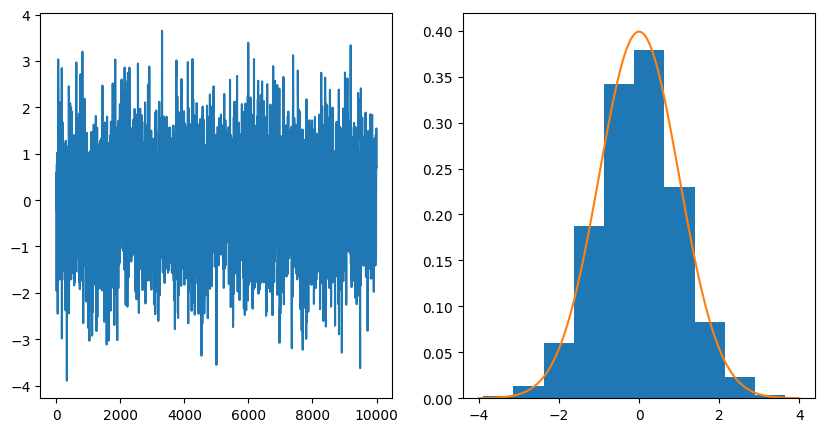

In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

p_x_pdf = lambda x: stats.norm().pdf(x)   # target
mh_tuning_parameter = 1.5
q_xt_given_xtm1 = lambda x: stats.norm(x, scale=mh_tuning_parameter) # proposal
proposal_distribution = q_xt_given_xtm1

m = 10000
x = np.zeros(m)
rejections = 0
for t in range(1,m):
    x_tilde = proposal_distribution(x[t-1]).rvs()  # sample a proposal state
    acceptance_probability = min(1, p_x_pdf(x_tilde)/p_x_pdf(x[t-1]))
    if stats.uniform().rvs() < acceptance_probability:
        x[t] = x_tilde
    else:
        x[t] = x[t-1]
        rejections += 1

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(x)
ax[1].hist(x, density=True)
x_support = np.linspace(-4,4,301)
ax[1].plot(x_support, p_x_pdf(x_support));

## Part B: What is MH?


### Why doesn't this work?


NOTE: the autocorrelation is a measure of how correlated the t'th sample is with the first sample. Once the autocorrelation hits 0, any correlation is effectively 0.
Then the approximation_stop (number of steps until autocorrelation=0) gives us how many samples we need to draw until we get independent samples. Effectively, the samples become i.i.d. if we take one sample every approximation_stop samples.

However, the actual amount of information in the chain is the effective sample size (ESS). Even if the samples are slightly dependent, the effective sample size tells us we have information equivalent to that amount of samples.

**To check:** is effective sample size equal to independent identically distributed samples?

ESS tells us the approximate precision of our Monte Carlo estimates relative to what we'd get with independent samples. More specifically:

For estimating expectations (means), if we have an ESS of n, then the variance of our MCMC mean estimate will be approximately the same as if we had n i.i.d. samples. This means:
Var(MCMC mean with N samples) ≈ σ²/(ESS)
where σ² is the population variance of the target distribution.

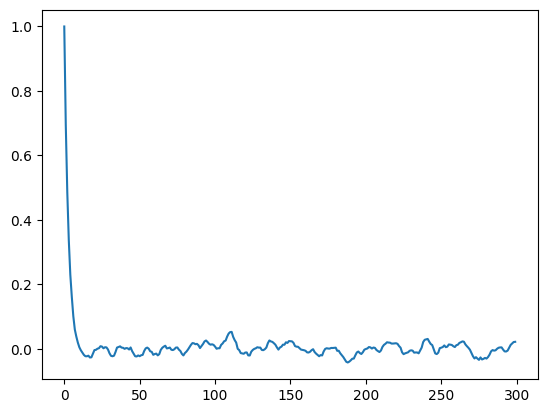

In [ ]:
# This is a plot of the k'th order autocorrelations.
# 1st order autocorrelations corresponds to adjacent samples (lag 1),
# 2nd order is for samples 2 steps apart (lag 2),
# k'th order is for samples k steps apart (lag k)
K = 300
autocorrelations = np.ones(K)
for t_plus_k in range(1, K):
    autocorrelations[t_plus_k] = np.corrcoef(x[:-t_plus_k], x[t_plus_k:])[0,1]

plt.plot(autocorrelations);

### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$

which is based on the relative value of $m$ between
- $\textrm{Var}\left(\frac{1}{n}{\sum_{t=1}^n x^{(t)}}\right) = \frac{\sigma^2}{n}$ under i.i.d. sampling and the actual
- $\begin{align}\textrm{Var}\left(\frac{1}{m}\sum_{t=1}^m x^{(t)}\right) &={} \frac{1}{m^2}\left(\sum_{t=1}^m \textrm{Var}\left(x^{(t)}\right) + \sum_{t \neq t'} \textrm{Cov}(x^{(t)},x^{(t')})\right)\\ &={} \frac{1}{m^2}\left(m \sigma^2 + \sum_{t \neq t'} \sigma^2 \rho_{t,t'}\right)\\ &\approx{} \frac{1}{m^2}\left(m \sigma^2+2m \sigma^2 \sum_{k=1}^m\rho_k\right) \approx \frac{\sigma^2}{m}\left(1+2  \sum_{k=1}^\infty\rho_k\right) \end{align}$
- Now call $n\rightarrow n_{\textrm{eff}}$ and solve for $n_{\textrm{eff}}$ in $\frac{\sigma^2}{n_{\textrm{eff}}} = \frac{\sigma^2}{m}\left(1+2  \sum_{k=1}^\infty\rho_k\right)$ which gives our result showing what our dependent samples would have counted for relative to an i.i.d. sample size count


\begin{align*}
n_{eff} s2 = m s2 + 2ms2 \sum r\\
n_{eff} = m + 2m \sum r\\
m*m/n_{eff} = m/(1+ 2  \sum r)
\end{align*}

In [ ]:
m / (1 + 2*autocorrelations[1:100].sum())

2107.0500246084366

(11, 1898.6684834260702)

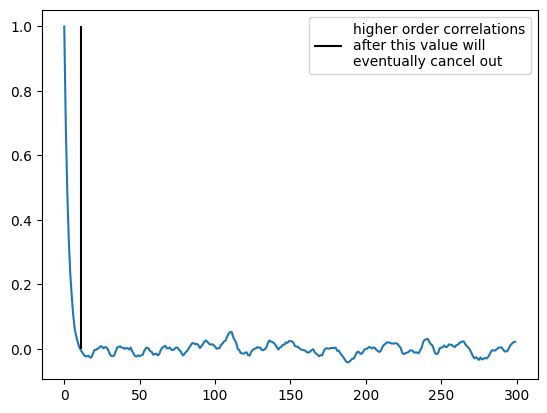

In [ ]:
K = 300
autocorrelations = np.ones(K)
for t_plus_k in range(1, K):
    autocorrelations[t_plus_k] = np.corrcoef(x[:-t_plus_k], x[t_plus_k:])[0,1]

approximation_stop = (autocorrelations < 0).cumsum()
approximation_stop = approximation_stop*np.arange(K)
approximation_stop = min(approximation_stop[approximation_stop>0])

plt.plot(autocorrelations)
plt.vlines(approximation_stop, ymin=0, ymax=1, color='k',
           label='higher order correlations\nafter this value will\neventually cancel out')
plt.legend()

# effective sample size
approximation_stop, m / (1 + 2*autocorrelations[1:approximation_stop].sum())

In [ ]:
10000/14

714.2857142857143

### Rejection Rate

The **rejection rate** of the **Metropolis Hastings** algorithm given above is something else that we should keep in mind.

#### Q1: Is a high rejection rate benefiicial or detrimental for the effective sample size calculation?

#### Q2: What is the relationship between the proposal distribution and the rejection rate?

In [ ]:
rejections/m

0.4107

(NOTE: MCMC is for sampling from some posterior distribution. We assume we had some data $x$ which gave us the posterior distribution)

Note that making a histogram and then generating a credible interval for the histogram is where the Monte Carlo in MCMC comes from: it's a Monte Carlo estimate.

Note: for Bayesian inference, we don't particularly care that the samples are dependent or anything, merely that it fills out the histogram in the right way so that we can get good credible intervals.

the idea is: did you run your Markov chain long enough so that you believe the histogram it produces?

### Why does this work?

> *Changing and hinting with the the notation to begin being suggestive about our purposes...*

If we have a **stationary distribution** $p(\theta \color{gray}{|x})$ then **transition distribution (kernel)** $p$ (not to be confused with the **Metropolis-Hastings prposal distribution** $q$!) produces a sample from this **stationary distribution** if the ***Markov chain*** it produces is ***reversible***, meaning that

$\require{cancel}
\begin{align*}
p(\theta^{(t)}|\theta^{(t-1)})p(\theta^{(t-1)}\color{gray}{|x}) & = {}  p(\theta^{(t-1)}|\theta^{(t)})p(\theta^{(t)}\color{gray}{|x})\\\\
& \textrm{But is this true if we use a Metropolis-Hastings transition distribution (kernel)?}
\\\\
p(\theta^{(t)}\color{gray}{|x}) & \overset{MH}{=} {} \frac{\alpha_{\textrm{accept prob}}^{\textrm{forward}} q(  \theta^{(t)}| \theta^{(t-1)})}{\alpha_{\textrm{accept prob}}^{\textrm{backward}} q(  \theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x})\\
p( \theta^{(t)}\color{gray}{|x}) & = {} \frac{\min\left(1,\frac{p( \theta^{(t)}\color{gray}{|x})}{p(\theta^{(t-1)}\color{gray}{|x})}\frac{q(\theta^{(t-1)}| \theta^{(t)})}{q( \theta^{(t)}|\theta^{(t-1)})}\right) q( \theta^{(t)}|\theta^{(t-1)})}{\min\left(1,\frac{p( \theta^{(t-1)}\color{gray}{|x})}{p( \theta^{(t)}\color{gray}{|x})}\frac{q( \theta^{(t)}| \theta^{(t-1)})}{q( \theta^{(t-1)}| \theta^{(t)})}\right) q(  \theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x})\\\\
& \textrm{The fractions in the "$\min$" in the numerator or denomenator are reciprocals}\\
& \textrm{thus regardless of if the numerator fraction is equal to, greater than, or less than $1$}\\\\
p( \theta^{(t)}\color{gray}{|x}) & = {} \frac{p( \theta^{(t)}\color{gray}{|x})}{p(\theta^{(t-1)}\color{gray}{|x})}\frac{q(\theta^{(t-1)}| \theta^{(t)})}{q( \theta^{(t)}|\theta^{(t-1)})} \frac{q\theta^{(t)}|\theta^{(t-1)})}{q(\theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x}) \\\\
\xcancel{p( \theta^{(t)}\color{gray}{|x})} & = {} \frac{\xcancel{p(\theta^{(t)}\color{gray}{|x})}}{\xcancel{p(\theta^{(t-1)}\color{gray}{|x})}}\frac{\cancel{q(\theta^{(t-1)}| \theta^{(t)})}}{\cancel{q( \theta^{(t)}|\theta^{(t-1)})}} \frac{\cancel{q\theta^{(t)}|\theta^{(t-1)})}}{\cancel{q(\theta^{(t-1)}|\theta^{(t)})}}\xcancel{p(\theta^{(t-1)}\color{gray}{|x})}\\  \longrightarrow \quad 1 & ={} 1 \quad \textrm{ so the equation is true and reversibility holds}
\end{align*}$

This illustrates how the entire design and purpose of the **Metropolis-Hastings** algorithm specification (which seemingly appeared magically out of thin air) is in fact based on "reverse engineering" (if you will please excuse the pun) exactly what is needed to create a **reversible Markov Chain** (whose **stationary distribution** is the **target** of the **Metropolis-Hastings** algorithm).

## Part C: Back to Gibbs sampling

**Gibbs sampling** also creates a **reversible Markov Chain** whereby the samples, forwards or backwards, are from the same **stationary distribution** (which is the **joint posterior distribution** of the (random variable) parameters of the **full conditional (posterior) distributions**


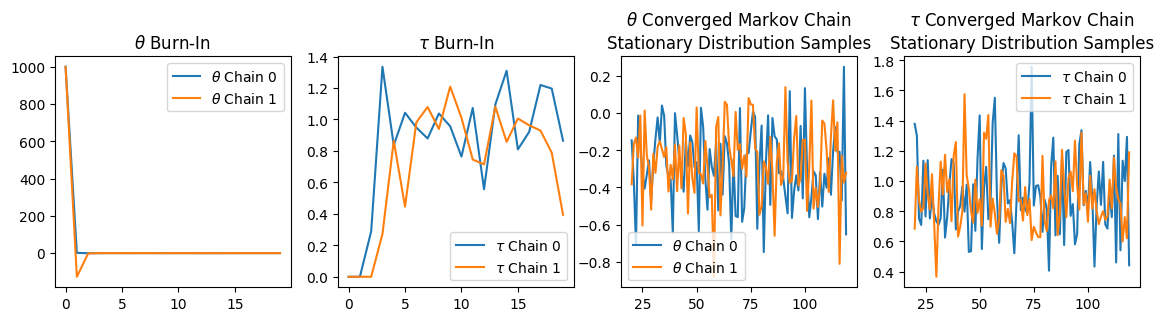

In [ ]:
# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 1000  # initialization
for c in range(C):
    for g in range(1,G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        tau[c,g] = \
        stats.gamma(a=n/2+1,
                    scale=2/((x-theta[c,g-1])**2).sum()).rvs()
        theta[c,g] = \
        stats.norm(x.mean(),
                   scale=1/np.sqrt(tau[c,g]*n)).rvs()

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

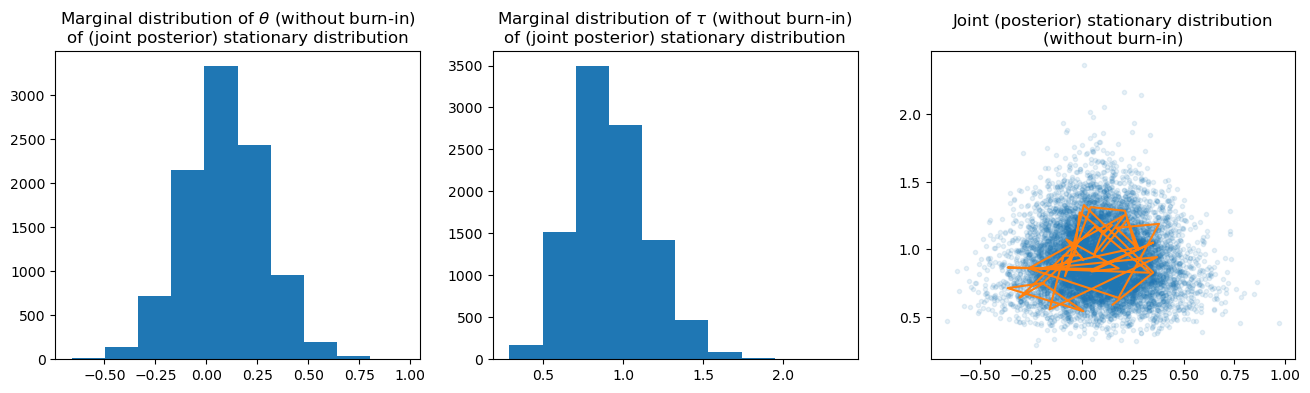

In [ ]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

## Metropolis within Gibbs

1. All **full conditional distributions** are proportional to the **joint**.
2. A **Metropolis-Hastings** step can sample from a **full conditional** by proposing a sample and accepting it according to the MH acceptance probability.
3. The target density in the MH acceptance probability appears in the numerator and denomenator so it's normalizing constants cancel and all that's needed

Accepting draws from a ***proposal distribution***

$\tilde \theta^{(t)} \sim q(\tilde \theta^{(t)}|\theta^{(t-1)})$

according to

$\require{cancel}
\theta^{(t)} = \left\{\begin{array}{ll}
\tilde \theta^{(t)} & \text{with probability } \min\bigg(1,\frac{p(\tilde \theta^{(t)}|\tau^{(t)},\mathbf{x})}{p(\theta^{(t-1)}|\tau^{(t)},\mathbf{x})}\overset{\textrm{if symmetric}}{\cancel{\frac{q(\theta^{(t-1)}|\tilde \theta^{(t)})}{q(\tilde \theta^{(t)}|\theta^{(t-1)})}}^1}\bigg) \\
\theta^{(t-1)} & \text{otherwise}\\\\
\end{array}\right.$

will produce draws from $p(\theta^{(t)}|\tau^{(t)},\mathbf{x})$.

If we don't know the **full conditional distributions** *analytically* we can't use the *simple version* of **Gibbs sampling**. *But we do know the full conditional distributions proportionally up to their normalizing constants* and the unknown normalizing constants cancel in the target density ratios

$\frac{p(\tilde \theta^{(t)}|\tau^{(t)},\mathbf{x})}{p(\theta^{(t-1)}|\tau^{(t)},\mathbf{x})} = \frac{p(\tilde \theta^{(t)},\tau^{(t)},\mathbf{x})}{p(\theta^{(t-1)},\tau^{(t)},\mathbf{x})} = \frac{p(\mathbf{x}|\tilde \theta^{(t)},\tau^{(t)})p(\tilde \theta^{(t)})}{p(\mathbf{x}|\theta^{(t-1)},\tau^{(t)})p(\theta^{(t-1)})}$

so all we need is the **joint distribuiton** (as a function of the parameter of the **full conditional**, here $\theta$).

And an analogous **Metropolis within Gibbs** step exists for $\tau^{(t)}$.


In [ ]:
# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 1000  # initialization
for c in range(C):
    for g in range(1,G):

        # the likelihood*prior as a function of tau
        # is proportional to the full conditional of tau
        # all of which are proportion to the joint as a function of tau
        tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c,g-1],
                                                     scale=1/(tau_)**0.5).pdf(x))*\
                                  stats.expon(scale=1).pdf(tau_)
                                  # arbitrarily chosen tau prior
        # arbitrarily chosen MH prosal distribution for tau
        tau_propsal = stats.expon(scale=2)
        tau_tilde = tau_propsal.rvs()

        mh_calc = (tau_target(tau_tilde)/tau_target(theta[c,g-1]))*\
        (tau_propsal.pdf(theta[c,g-1]))/tau_propsal.pdf(tau_tilde)
        acceptance_probability = min(1, mh_calc)
        if stats.uniform().rvs() < acceptance_probability:
            tau[c,g] = tau_tilde
        else:
            tau[c,g] = tau[c,g-1]

        theta[c,g] = joint * prior_theta  # check this step


## Homework

---





### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler.
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*



### Q1 Answer

   I “update” each parameter in turn by proposing a candidate and accepting it with a Metropolis-Hastings probability. For $\tau$, the probability is
   \begin{align}
   \alpha_\tau = \min\left\{1,\frac{p(\theta,\tilde\tau\mid x)}{p(\theta,\tau\mid x)}\frac{q(\tau\mid\tilde\tau)}{q(\tilde\tau\mid\tau)}\right\}.
   \end{align}

   For $\theta$, I use a symmetric proposal, and because of the proposal being symmetric, the right term cancels out, yielding this probability:
   \begin{align}
   \alpha_\theta = \min\left\{1,\frac{p(\theta,\tilde\tau\mid x)}{p(\theta,\tau\mid x)}\right\}.
   \end{align}

   The joint posterior of $\theta$ and $\tau$ is proportional to the product of likelihood and priors:
   \begin{align}
   p(\theta,\tau\mid x) \propto \Biggl[\prod_{i=1}^n N\left(x_i \mid \,\theta,\,1/\tau\right)\Biggr]\,p(\theta)\,p(\tau).
   \end{align}

   In the demonstration I use the same simulation setup as in my previous Gibbs sampler (with “weak” priors) but do not derive the full conditionals explicitly.

   For $\tau$ (which must be positive) I choose an independent proposal distribution that I set equal to the prior $p(\tau)$, which is $\operatorname{Gamma}(\alpha/2,scale=2/\lambda)$ in this example. For $\theta$ we use the Normal symmetric random-walk proposal.

To specify, this is the formulation of the setup:
- Data: $x_1,\dots,x_n$ are drawn from $N(\theta,1/\tau)$.
- Priors: $p(\theta)=N(\theta_0, 1/\tau_0)$ and  
  $p(\tau)= \operatorname{Gamma}(\alpha/2,scale=2/\lambda)$. Note that this is a specialized case of the $\operatorname{Gamma}$ distribution with certain hyperparameters.

Comparing the Bayesian inference of Metropolis-within-Gibbs (MWG) against the pure Gibbs sampler, we find that the Gibbs sampler produces a smoother, more symmetric posterior whereas MWG shows more jaggedness and irregular peaks. This suggests better mixing in the Gibbs sampler, whereas MWG suffered from poor mixing. This can also be seen in the initial traceplots for the burn in.

The smoother histogram distribution of the Gibbs sampler means it may provide a more reliable estimate of uncertainty in the posterior, but ultimately, both methods capture the true θ (red dotted line) within their 95% credible interval. The Gibbs sampler appears to have marginally tighter credible intervals, but both seem centered appropriately around the true value.

The main difference causing this difference is that the Gibbs sampler uses exact conditional distributions, whereas MWG must rely on proposal distributions that may not match the posterior shape well, and MWG's acceptance/rejection step leads to more correlation in the chain.

Overall, I believe that this shows why pure Gibbs sampling may be preferable when we are able to compute full conditionals.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Select hyperparameters and get the simulated data:

In [37]:
# ---------- PARAMETERS YOU CAN TWEAK ----------

# Weak set of Hyperparameters for priors (data dominates)
alpha  = 2.0       # Gamma shape = alpha/2
lam    = 2.0       # Gamma rate  = lam/2
# ---------------------------------------------


# True parameters for data simulation
m_true = 75       # true mean (for simulation)
tau_true = 0.5       # true precision
n = 30            # sample size

# Hyperparameters (weakly informative priors)
theta0 = 80.0     # prior mean for theta
tau0   = 1.0    # prior precision for theta

# Simulate data from N(m_true, tau_true)
x = stats.norm(loc=m_true, scale=1 / np.sqrt(tau_true)).rvs(size=n)

# Number of chains and iterations
C = 1
G = 10000

First, a Metropolis-within-Gibbs sampler with a poorly tuned proposal. Notice that the mixing of the $\theta$ Markov chain is very poor.

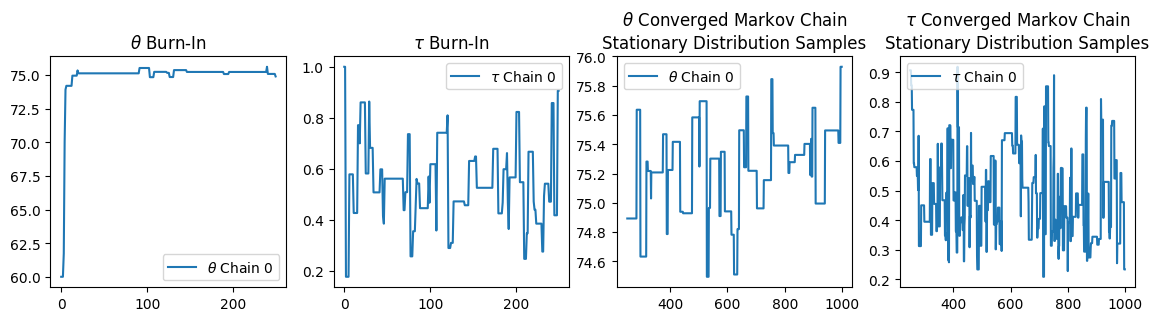

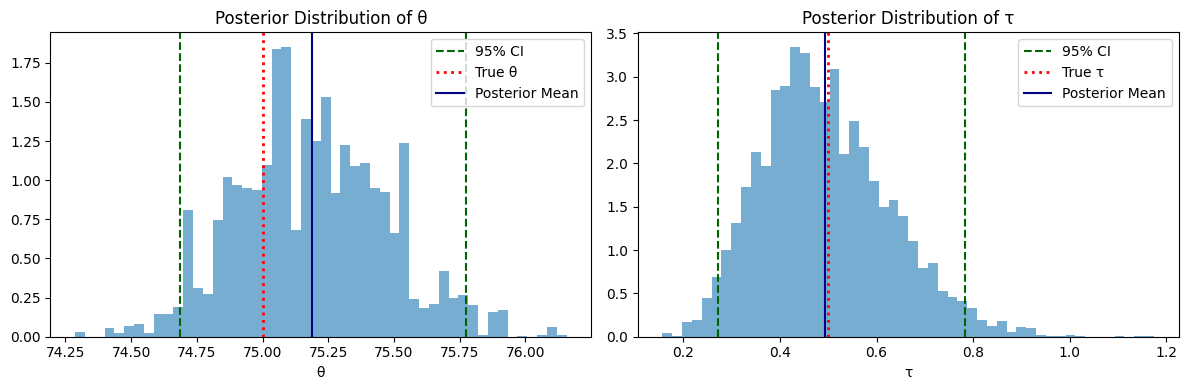

Metropolis-Within-Gibbs Bayesian Inference Results (n = 30):
True population mean (θ): 75.00
95% Credible Interval for θ: [74.69, 75.77]
Posterior mean for θ: 75.19

True population τ: 0.50
95% Credible Interval for τ: [0.27, 0.78]
Posterior mean for τ: 0.49


In [38]:
######## Q1: This is a Metropolis-within-Gibbs sampler with a poorly-tuned proposal.

def log_joint(theta, tau, x, theta0, tau0):
    """
    Unnormalized log joint density for (theta, tau) given data x.
    Likelihood: product_{i=1}^n Normal(x_i; theta, variance=1/tau)
    Prior for theta: Normal(theta0, 1/tau0)
    Prior for tau: Gamma(shape=alpha/2, scale=2/lam)
    Constants that cancel are omitted
    """
    n = len(x)
    # Log-likelihood (ignoring additive constants)
    # Note: pdf of N(mu, sigma) uses sigma as standard deviation, and here sigma = 1/sqrt(tau)
    log_lik = 0.5 * n * np.log(tau) - 0.5 * tau * np.sum((x - theta)**2)

    # Prior for theta (Normal with variance tau0)
    log_prior_theta = stats.norm.logpdf(theta, loc=theta0, scale=1/np.sqrt(tau0))

    # Prior for tau: Gamma with shape=alpha/2 and scale=2/lam.
    log_prior_tau = stats.gamma.logpdf(tau, a=alpha/2, scale=2/lam)

    return log_lik + log_prior_theta + log_prior_tau

# ---------------------------
# Metropolis-within-Gibbs Sampler (Q1)
# ---------------------------

proposal_sd_theta = 5  # tuning parameter for theta proposals

# Allocate arrays to store samples
theta_chain = np.zeros((C, G))
tau_chain   = np.zeros((C, G))

# Initialize chains (starting values can be arbitrary)
theta_chain[:, 0] = 60.0
tau_chain[:, 0] = 1

for c in range(C):
    for g in range(1, G):
        # Current state
        theta_current = theta_chain[c, g-1]
        tau_current   = tau_chain[c, g-1]

        # --- Update tau ---
        # Propose tau_tilde independently from the proposal (which we choose as the prior for tau)
        tau_tilde = stats.gamma(a=alpha/2, scale=2/lam).rvs()

        # Compute log joint (only the parts that depend on tau; theta remains fixed)
        log_target_tilde = log_joint(theta_current, tau_tilde, x, theta0, tau0)
        log_target_current = log_joint(theta_current, tau_current, x, theta0, tau0)

        # Since the proposal density is the same as p(tau), include the proposal ratio:
        log_q_ratio = stats.gamma(a=alpha/2, scale=2/lam).logpdf(tau_current) - stats.gamma(a=alpha/2, scale=2/lam).logpdf(tau_tilde)
        delta_tau = (log_target_tilde - log_target_current) + log_q_ratio
        if delta_tau > 0:
            alpha_tau = 1
        else:
            alpha_tau = min(1, np.exp(delta_tau))

        if stats.uniform().rvs() < alpha_tau:
            tau_chain[c, g] = tau_tilde
        else:
            tau_chain[c, g] = tau_current

        # --- Update theta ---
        # Propose theta_tilde from a symmetric random walk
        theta_tilde = theta_current + stats.norm(scale=proposal_sd_theta).rvs()

        # Compute log joint (theta changes, tau fixed at the updated value)
        log_target_tilde = log_joint(theta_tilde, tau_chain[c, g], x, theta0, tau0)
        log_target_current = log_joint(theta_current, tau_chain[c, g], x, theta0, tau0)

        # For a symmetric proposal, the proposal densities cancel.
        delta_theta = log_target_tilde - log_target_current
        if delta_theta > 0:
            alpha_theta = 1
        else:
            alpha_theta = min(1, np.exp(delta_theta))

        if stats.uniform().rvs() < alpha_theta:
            theta_chain[c, g] = theta_tilde
        else:
            theta_chain[c, g] = theta_current

# ---------------------------
# Diagnostics for MWG
# ---------------------------
burn = 250
posterior_theta = theta_chain[0, burn:]
posterior_tau   = tau_chain[0, burn:]

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
demo = 1000
for c in range(C):
    ax[0].plot(theta_chain[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau_chain[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta_chain[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau_chain[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

theta_ci = np.quantile(posterior_theta, [0.025, 0.975])
sigma_ci = np.quantile(posterior_tau, [0.025, 0.975])

# Plots of posterior distributions for θ and σ
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# -- Posterior of θ
ax[0].hist(posterior_theta, bins=50, density=True, alpha=0.6)
ax[0].axvline(theta_ci[0], color="darkgreen", linestyle="--", label="95% CI")
ax[0].axvline(theta_ci[1], color="darkgreen", linestyle="--")
ax[0].axvline(m_true, color="red", linestyle=":", linewidth=2, label="True θ")
ax[0].axvline(posterior_theta.mean(), color="navy", label="Posterior Mean")
ax[0].set_title("Posterior Distribution of θ")
ax[0].set_xlabel("θ")
ax[0].legend()

# -- Posterior of σ
ax[1].hist(posterior_tau, bins=50, density=True, alpha=0.6)
ax[1].axvline(sigma_ci[0], color="darkgreen", linestyle="--", label="95% CI")
ax[1].axvline(sigma_ci[1], color="darkgreen", linestyle="--")
ax[1].axvline(tau_true, color="red", linestyle=":", linewidth=2, label="True τ")
ax[1].axvline(posterior_tau.mean(), color="navy", label="Posterior Mean")
ax[1].set_title("Posterior Distribution of τ")
ax[1].set_xlabel("τ")
ax[1].legend()

plt.tight_layout()
plt.show()


print(f"Metropolis-Within-Gibbs Bayesian Inference Results (n = {n}):")
print(f"====================================")
print(f"True population mean (θ): {m_true:.2f}")
print(f"95% Credible Interval for θ: [{theta_ci[0]:.2f}, {theta_ci[1]:.2f}]")
print(f"Posterior mean for θ: {posterior_theta.mean():.2f}")
print()
print(f"True population τ: {tau_true:.2f}")
print(f"95% Credible Interval for τ: [{sigma_ci[0]:.2f}, {sigma_ci[1]:.2f}]")
print(f"Posterior mean for τ: {posterior_tau.mean():.2f}")

Next, a Metropolis-within-Gibbs sampler with a well-tuned proposal. Notice that the traceplot for $\theta$ displays much better mixing than the previous one.

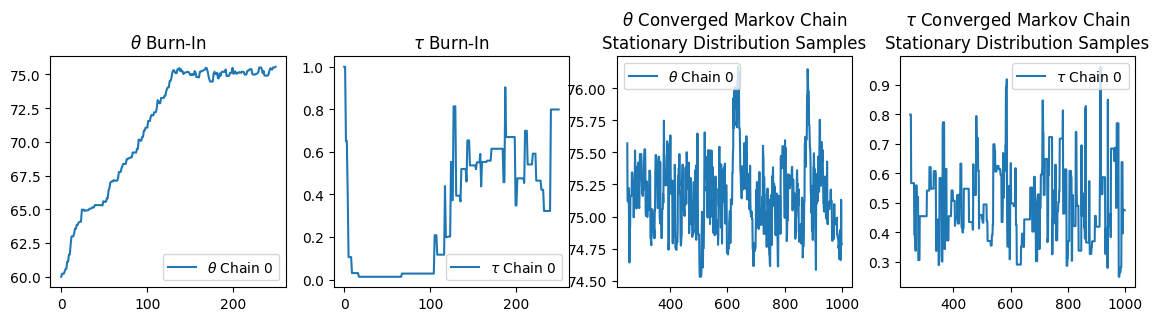

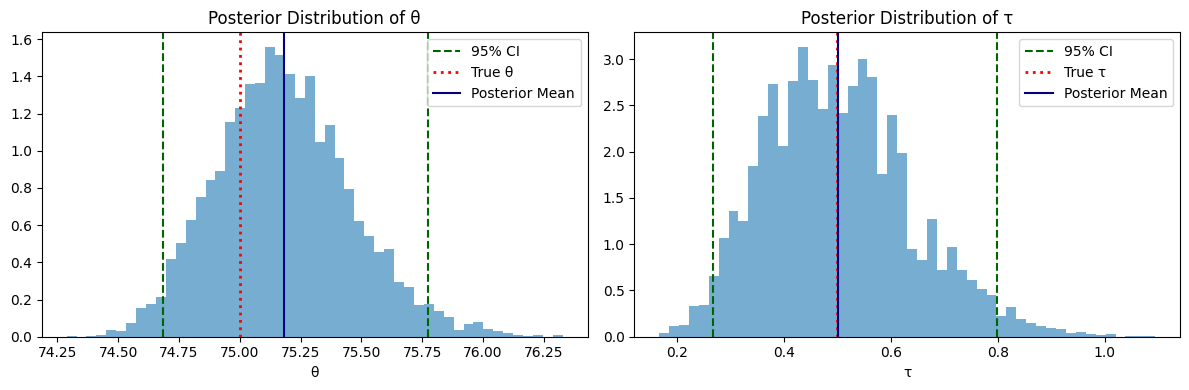

Metropolis-Within-Gibbs Bayesian Inference Results (n = 30):
True population mean (θ): 75.00
95% Credible Interval for θ: [74.68, 75.78]
Posterior mean for θ: 75.18

True population τ: 0.50
95% Credible Interval for τ: [0.27, 0.80]
Posterior mean for τ: 0.50


In [39]:
######## Q1: This is a Metropolis-within-Gibbs sampler with a well-tuned proposal.

def log_joint(theta, tau, x, theta0, tau0):
    """
    Unnormalized log joint density for (theta, tau) given data x.
    Likelihood: product_{i=1}^n Normal(x_i; theta, variance=1/tau)
    Prior for theta: Normal(theta0, 1/tau0)
    Prior for tau: Gamma(shape=alpha/2, scale=2/lam)
    Constants that cancel are omitted
    """
    n = len(x)
    # Log-likelihood (ignoring additive constants)
    # Note: pdf of N(mu, sigma) uses sigma as standard deviation, and here sigma = 1/sqrt(tau)
    log_lik = 0.5 * n * np.log(tau) - 0.5 * tau * np.sum((x - theta)**2)

    # Prior for theta (Normal with variance tau0)
    log_prior_theta = stats.norm.logpdf(theta, loc=theta0, scale=1/np.sqrt(tau0))

    # Prior for tau: Gamma with shape=alpha/2 and scale=2/lam.
    log_prior_tau = stats.gamma.logpdf(tau, a=alpha/2, scale=2/lam)

    return log_lik + log_prior_theta + log_prior_tau

# ---------------------------
# Metropolis-within-Gibbs Sampler (Q1)
# ---------------------------
# For tau, we use an independent Gamma proposal from the tau prior
# For theta, we use a Normal symmetric random-walk proposal.

proposal_sd_theta = 0.3  # tuning parameter for theta proposals

# Allocate arrays to store samples
theta_chain = np.zeros((C, G))
tau_chain   = np.zeros((C, G))

# Initialize chains (starting values can be arbitrary)
theta_chain[:, 0] = 60.0
tau_chain[:, 0] = 1

for c in range(C):
    for g in range(1, G):
        # Current state
        theta_current = theta_chain[c, g-1]
        tau_current   = tau_chain[c, g-1]

        # --- Update tau ---
        # Propose tau_tilde independently from the proposal (which we choose as the prior for tau)
        tau_tilde = stats.gamma(a=alpha/2, scale=2/lam).rvs()

        # Compute log joint (only the parts that depend on tau; theta remains fixed)
        log_target_tilde = log_joint(theta_current, tau_tilde, x, theta0, tau0)
        log_target_current = log_joint(theta_current, tau_current, x, theta0, tau0)

        # Since the proposal density is the same as p(tau), include the proposal ratio:
        log_q_ratio = stats.gamma(a=alpha/2, scale=2/lam).logpdf(tau_current) - stats.gamma(a=alpha/2, scale=2/lam).logpdf(tau_tilde)
        delta_tau = (log_target_tilde - log_target_current) + log_q_ratio
        if delta_tau > 0:
            alpha_tau = 1
        else:
            alpha_tau = min(1, np.exp(delta_tau))

        if stats.uniform().rvs() < alpha_tau:
            tau_chain[c, g] = tau_tilde
        else:
            tau_chain[c, g] = tau_current

        # --- Update theta ---
        # Propose theta_tilde from a symmetric random walk
        theta_tilde = theta_current + stats.norm(scale=proposal_sd_theta).rvs()

        # Compute log joint (theta changes, tau fixed at the updated value)
        log_target_tilde = log_joint(theta_tilde, tau_chain[c, g], x, theta0, tau0)
        log_target_current = log_joint(theta_current, tau_chain[c, g], x, theta0, tau0)

        # For a symmetric proposal, the proposal densities cancel.
        delta_theta = log_target_tilde - log_target_current
        if delta_theta > 0:
            alpha_theta = 1
        else:
            alpha_theta = min(1, np.exp(delta_theta))

        if stats.uniform().rvs() < alpha_theta:
            theta_chain[c, g] = theta_tilde
        else:
            theta_chain[c, g] = theta_current

# ---------------------------
# Diagnostics for MWG
# ---------------------------
burn = 250
posterior_theta = theta_chain[0, burn:]
posterior_tau   = tau_chain[0, burn:]

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
demo = 1000
for c in range(C):
    ax[0].plot(theta_chain[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau_chain[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta_chain[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau_chain[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

theta_ci = np.quantile(posterior_theta, [0.025, 0.975])
sigma_ci = np.quantile(posterior_tau, [0.025, 0.975])

# Plots of posterior distributions for θ and σ
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# -- Posterior of θ
ax[0].hist(posterior_theta, bins=50, density=True, alpha=0.6)
ax[0].axvline(theta_ci[0], color="darkgreen", linestyle="--", label="95% CI")
ax[0].axvline(theta_ci[1], color="darkgreen", linestyle="--")
ax[0].axvline(m_true, color="red", linestyle=":", linewidth=2, label="True θ")
ax[0].axvline(posterior_theta.mean(), color="navy", label="Posterior Mean")
ax[0].set_title("Posterior Distribution of θ")
ax[0].set_xlabel("θ")
ax[0].legend()

# -- Posterior of σ
ax[1].hist(posterior_tau, bins=50, density=True, alpha=0.6)
ax[1].axvline(sigma_ci[0], color="darkgreen", linestyle="--", label="95% CI")
ax[1].axvline(sigma_ci[1], color="darkgreen", linestyle="--")
ax[1].axvline(tau_true, color="red", linestyle=":", linewidth=2, label="True τ")
ax[1].axvline(posterior_tau.mean(), color="navy", label="Posterior Mean")
ax[1].set_title("Posterior Distribution of τ")
ax[1].set_xlabel("τ")
ax[1].legend()

plt.tight_layout()
plt.show()


print(f"Metropolis-Within-Gibbs Bayesian Inference Results (n = {n}):")
print(f"====================================")
print(f"True population mean (θ): {m_true:.2f}")
print(f"95% Credible Interval for θ: [{theta_ci[0]:.2f}, {theta_ci[1]:.2f}]")
print(f"Posterior mean for θ: {posterior_theta.mean():.2f}")
print()
print(f"True population τ: {tau_true:.2f}")
print(f"95% Credible Interval for τ: [{sigma_ci[0]:.2f}, {sigma_ci[1]:.2f}]")
print(f"Posterior mean for τ: {posterior_tau.mean():.2f}")

Then, the Gibbs sampler from the last homework:

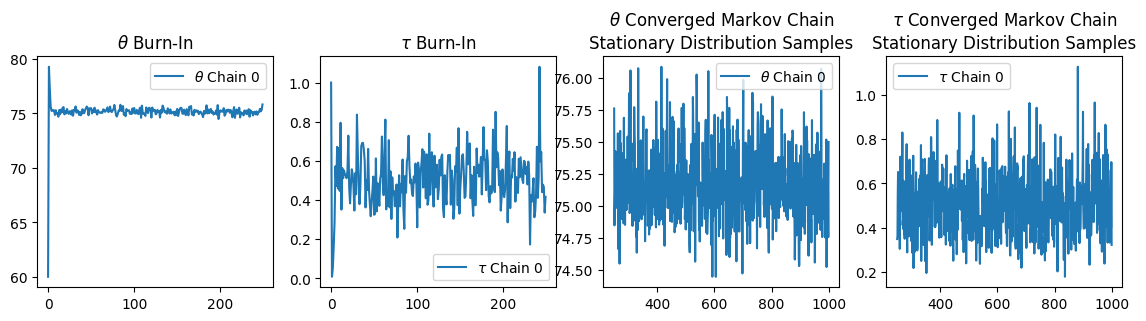

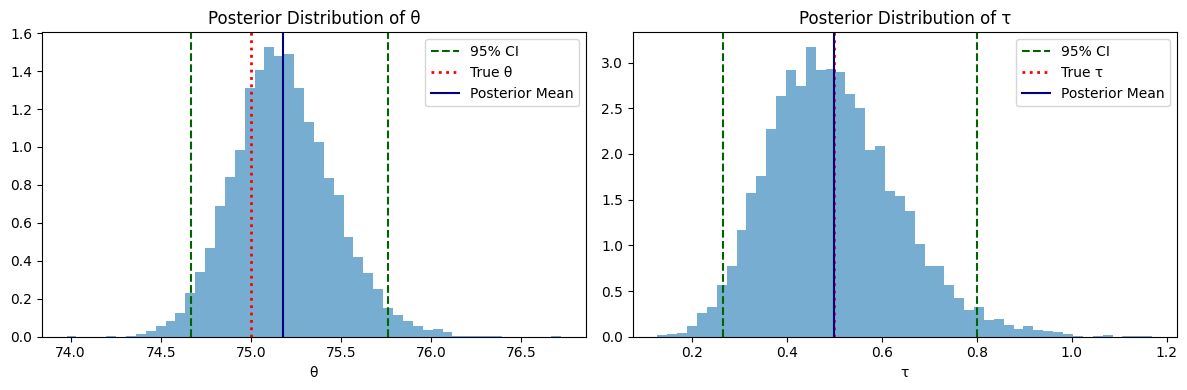

Gibbs sampler Bayesian Inference Results (n = 30):
True population mean (θ): 75.00
95% Credible Interval for θ: [74.67, 75.76]
Posterior mean for θ: 75.18

True population τ: 0.50
95% Credible Interval for τ: [0.27, 0.80]
Posterior mean for τ: 0.50


In [40]:
#### This code is from Q2 from the last homework

# Allocate arrays
theta = np.zeros([C, G])
tau   = np.zeros([C, G])

# Initial guesses
theta[:, 0] = 60.0
tau[:,   0] = 1.0

for c in range(C):
    for g in range(1, G):

        # --- Sample tau^(g) from p(tau | theta^(g-1), x) ---
        # shape = (n + alpha) / 2
        # rate  = (lambda + sum_squares) / 2
        sum_squares = np.sum((x - theta[c, g-1])**2)
        shape_tau = 0.5 * (n + alpha)
        rate_tau  = 0.5 * (lam + sum_squares)
        # In scipy, scale = 1/rate
        tau[c,g] = stats.gamma(a=shape_tau, scale=1.0/rate_tau).rvs()

        # --- Sample theta^(g) from p(theta | tau^(g), x) ---
        post_precision = tau[c,g]*n + 1.0/tau0
        post_mean      = (
            (tau[c,g]*n)*x.mean() + (theta0 / tau0)
        ) / post_precision
        post_sd        = np.sqrt(1.0 / post_precision)
        theta[c,g]     = stats.norm(loc=post_mean, scale=post_sd).rvs()

# ---------------------------
# Diagnostics for Pure Gibbs
# ---------------------------
burn = 250
posterior_theta = theta[0, burn:]
posterior_tau   = tau[0, burn:]

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
demo = 1000
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

theta_ci = np.quantile(posterior_theta, [0.025, 0.975])
sigma_ci = np.quantile(posterior_tau, [0.025, 0.975])

# Plots of posterior distributions for θ and σ
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# -- Posterior of θ
ax[0].hist(posterior_theta, bins=50, density=True, alpha=0.6)
ax[0].axvline(theta_ci[0], color="darkgreen", linestyle="--", label="95% CI")
ax[0].axvline(theta_ci[1], color="darkgreen", linestyle="--")
ax[0].axvline(m_true, color="red", linestyle=":", linewidth=2, label="True θ")
ax[0].axvline(posterior_theta.mean(), color="navy", label="Posterior Mean")
ax[0].set_title("Posterior Distribution of θ")
ax[0].set_xlabel("θ")
ax[0].legend()

# -- Posterior of σ
ax[1].hist(posterior_tau, bins=50, density=True, alpha=0.6)
ax[1].axvline(sigma_ci[0], color="darkgreen", linestyle="--", label="95% CI")
ax[1].axvline(sigma_ci[1], color="darkgreen", linestyle="--")
ax[1].axvline(tau_true, color="red", linestyle=":", linewidth=2, label="True τ")
ax[1].axvline(posterior_tau.mean(), color="navy", label="Posterior Mean")
ax[1].set_title("Posterior Distribution of τ")
ax[1].set_xlabel("τ")
ax[1].legend()

plt.tight_layout()
plt.show()


print(f"Gibbs sampler Bayesian Inference Results (n = {n}):")
print(f"====================================")
print(f"True population mean (θ): {m_true:.2f}")
print(f"95% Credible Interval for θ: [{theta_ci[0]:.2f}, {theta_ci[1]:.2f}]")
print(f"Posterior mean for θ: {posterior_theta.mean():.2f}")
print()
print(f"True population τ: {tau_true:.2f}")
print(f"95% Credible Interval for τ: [{sigma_ci[0]:.2f}, {sigma_ci[1]:.2f}]")
print(f"Posterior mean for τ: {posterior_tau.mean():.2f}")

Comparing the Bayesian inference of Metropolis-within-Gibbs (MWG) against the pure Gibbs sampler, we find that the
Gibbs sampler produces a smoother, more symmetric posterior whereas
MWG shows more jaggedness and irregular peaks. The extent of this for MWG depends on how we tune the proposal distribution used in the Metropolis-Hastings algorithm.
In general, a Gibbs sampler will have better mixing than a MWG sampler. This can also be seen in the initial traceplots for the burn in.

The smoother histogram distribution of the Gibbs sampler means it may provide a more reliable estimate of uncertainty in the posterior, but ultimately, both methods capture the true θ (red dotted line) within their 95% credible interval.
The Gibbs sampler appears to have marginally tighter credible intervals, but both seem centered appropriately around the true value.

The main difference causing this difference is that the
Gibbs sampler uses exact conditional distributions, whereas MWG must rely on proposal distributions that may not match the posterior shape well, and MWG's acceptance/rejection step leads to more correlation in the chain.

Overall, I believe that this shows why pure Gibbs sampling may be preferable when we are able to compute full conditionals.

### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*



### Q2 Answer

I will provide Bayesian inference: first with poorly tuned proposal parameters for Metropolis-Hastings, then with well-tuned parameters.

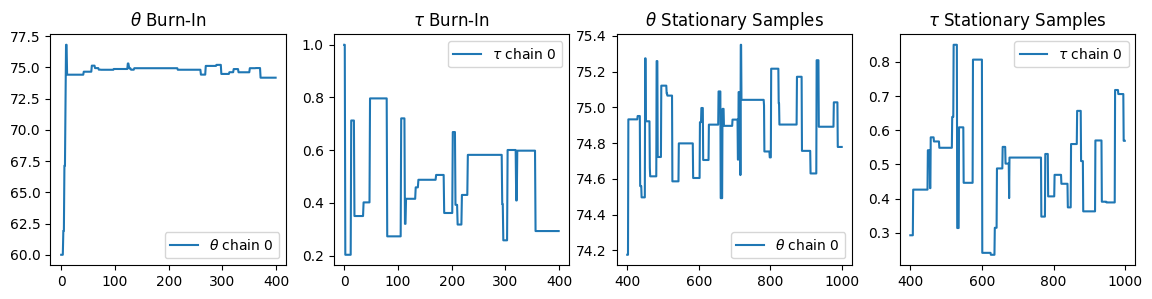

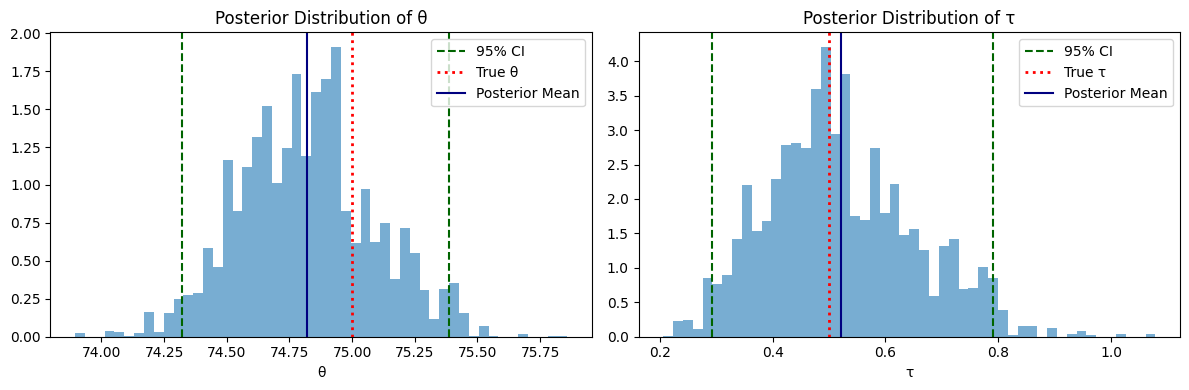

Metropolis-Within-Gibbs Bayesian Inference Results (n = 30):
True population mean (θ): 75.00
95% Credible Interval for θ: [74.32, 75.39]
Posterior mean for θ: 74.82

True population τ: 0.50
95% Credible Interval for τ: [0.29, 0.79]
Posterior mean for τ: 0.52


In [43]:
####### Poorly tuned parameters
# Hyperparameters for the prior on theta (now using a Cauchy prior)
theta0 = 80.0       # location parameter for the Cauchy prior on theta
# (For the Cauchy prior, we choose a scale parameter; here we use 10)
cauchy_scale = 10

# Allocate arrays to store samples
theta_chain = np.zeros((C, G))
tau_chain   = np.zeros((C, G))

# Initialize chains (starting values can be arbitrary)
theta_chain[:, 0] = 60.0
tau_chain[:, 0]   = 1.0

# ---------------------------
# Metropolis-within-Gibbs Sampler (Q2)
# ---------------------------
# Tuning parameters:
proposal_sd_theta = 5.0    # standard deviation for the symmetric random walk for theta
s_tau = 5.0                # tuning parameter for the dependent proposal for tau

# ---------------------------
# Define the joint (unnormalized) log density
# ---------------------------
def log_joint(theta, tau, x, theta0, cauchy_scale):
    """
    Unnormalized log joint density for (theta, tau) given data x.
    Likelihood:   ∏_{i=1}^n N(x_i; theta, variance=1/tau)
    Prior for theta: Cauchy(theta0, scale=cauchy_scale)
    Prior for tau: Gamma(shape=alpha/2, scale=2/lam)
    (Constants not depending on theta or tau are omitted.)
    """
    n = len(x)
    # Log-likelihood (using that sigma = 1/sqrt(tau))
    log_lik = 0.5 * n * np.log(tau) - 0.5 * tau * np.sum((x - theta)**2)

    # Prior for theta: use a Cauchy density (heavy–tailed)
    log_prior_theta = stats.cauchy.logpdf(theta, loc=theta0, scale=cauchy_scale)

    # Prior for tau: Gamma with shape=alpha/2 and scale=2/lam.
    log_prior_tau = stats.gamma.logpdf(tau, a=alpha/2, scale=2/lam)

    return log_lik + log_prior_theta + log_prior_tau


for c in range(C):
    for g in range(1, G):
        # Current state
        theta_current = theta_chain[c, g-1]
        tau_current   = tau_chain[c, g-1]

        # --- Update tau using a dependent (truncated normal) proposal ---
        # tau proposal is stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
        #         loc=tau_t_minus_1, scale=s)
        # We use: truncnorm(a=-tau_current/s_tau, b=inf, loc=tau_current, scale=s_tau)
        a_val = -tau_current / s_tau  # lower bound in standardized units
        tau_prop_dist = stats.truncnorm(a=a_val, b=np.inf, loc=tau_current, scale=s_tau)
        tau_tilde = tau_prop_dist.rvs()

        # Compute the forward proposal density: q(tau_tilde | tau_current)
        q_forward = tau_prop_dist.pdf(tau_tilde)
        # Compute the backward density: q(tau_current | tau_tilde)
        a_rev = -tau_tilde / s_tau
        q_backward = stats.truncnorm(a=a_rev, b=np.inf, loc=tau_tilde, scale=s_tau).pdf(tau_current)

        # Compute the log joint densities (theta remains fixed at theta_current)
        log_target_tilde = log_joint(theta_current, tau_tilde, x, theta0, cauchy_scale)
        log_target_current = log_joint(theta_current, tau_current, x, theta0, cauchy_scale)

        # Include the proposal correction
        log_q_ratio = np.log(q_backward) - np.log(q_forward)
        delta_tau = (log_target_tilde - log_target_current) + log_q_ratio

        # Use a safe evaluation so that if delta_tau > 0 we set alpha_tau = 1 without exponentiating
        if delta_tau > 0:
            alpha_tau = 1.0
        else:
            alpha_tau = np.exp(delta_tau)

        # Accept/reject step for tau
        if stats.uniform().rvs() < alpha_tau:
            tau_chain[c, g] = tau_tilde
        else:
            tau_chain[c, g] = tau_current

        # --- Update theta using a symmetric random-walk proposal ---
        theta_tilde = theta_current + stats.norm(scale=proposal_sd_theta).rvs()
        # Now tau remains fixed at the newly updated value
        log_target_tilde = log_joint(theta_tilde, tau_chain[c, g], x, theta0, cauchy_scale)
        log_target_current = log_joint(theta_current, tau_chain[c, g], x, theta0, cauchy_scale)
        delta_theta = log_target_tilde - log_target_current
        if delta_theta > 0:
            alpha_theta = 1.0
        else:
            alpha_theta = np.exp(delta_theta)

        if stats.uniform().rvs() < alpha_theta:
            theta_chain[c, g] = theta_tilde
        else:
            theta_chain[c, g] = theta_current

# ---------------------------
# Diagnostics for the Modified Sampler (Q2)
# ---------------------------
burn = 400
posterior_theta = theta_chain[0, burn:]
posterior_tau   = tau_chain[0, burn:]

fig, ax = plt.subplots(1, 4, figsize=(14,3))
ax[0].set_title(r"$\theta$ Burn-In")
ax[1].set_title(r"$\tau$ Burn-In")
ax[2].set_title(r"$\theta$ Stationary Samples")
ax[3].set_title(r"$\tau$ Stationary Samples")
demo = 1000
for c in range(C):
    ax[0].plot(theta_chain[c, :burn], label=r"$\theta$ chain " + str(c))
    ax[1].plot(tau_chain[c, :burn], label=r"$\tau$ chain " + str(c))
    ax[2].plot(np.arange(burn, demo), theta_chain[c, burn:demo], label=r"$\theta$ chain " + str(c))
    ax[3].plot(np.arange(burn, demo), tau_chain[c, burn:demo], label=r"$\tau$ chain " + str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

# Posterior summaries and plots:
theta_ci = np.quantile(posterior_theta, [0.025, 0.975])
tau_ci   = np.quantile(posterior_tau, [0.025, 0.975])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# Posterior of theta
ax[0].hist(posterior_theta, bins=50, density=True, alpha=0.6)
ax[0].axvline(theta_ci[0], color="darkgreen", linestyle="--", label="95% CI")
ax[0].axvline(theta_ci[1], color="darkgreen", linestyle="--")
ax[0].axvline(m_true, color="red", linestyle=":", linewidth=2, label="True θ")
ax[0].axvline(posterior_theta.mean(), color="navy", label="Posterior Mean")
ax[0].set_title("Posterior Distribution of θ")
ax[0].set_xlabel("θ")
ax[0].legend()

# Posterior of tau
ax[1].hist(posterior_tau, bins=50, density=True, alpha=0.6)
ax[1].axvline(tau_ci[0], color="darkgreen", linestyle="--", label="95% CI")
ax[1].axvline(tau_ci[1], color="darkgreen", linestyle="--")
ax[1].axvline(tau_true, color="red", linestyle=":", linewidth=2, label="True τ")
ax[1].axvline(posterior_tau.mean(), color="navy", label="Posterior Mean")
ax[1].set_title("Posterior Distribution of τ")
ax[1].set_xlabel("τ")
ax[1].legend()

plt.tight_layout()
plt.show()

print(f"Metropolis-Within-Gibbs Bayesian Inference Results (n = {n}):")
print("====================================")
print(f"True population mean (θ): {m_true:.2f}")
print(f"95% Credible Interval for θ: [{theta_ci[0]:.2f}, {theta_ci[1]:.2f}]")
print(f"Posterior mean for θ: {posterior_theta.mean():.2f}")
print()
print(f"True population τ: {tau_true:.2f}")
print(f"95% Credible Interval for τ: [{tau_ci[0]:.2f}, {tau_ci[1]:.2f}]")
print(f"Posterior mean for τ: {posterior_tau.mean():.2f}")

This is after tuning the proposal scaling parameters. Notice that the histograms are smoother and the Markov chain traceplots show noticeably better mixing.

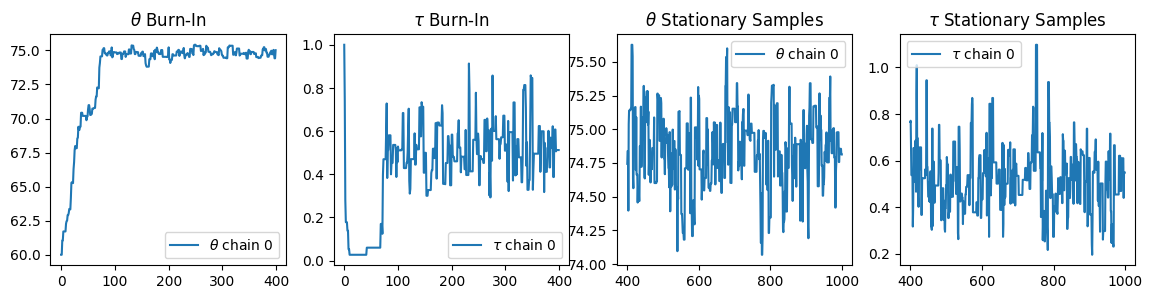

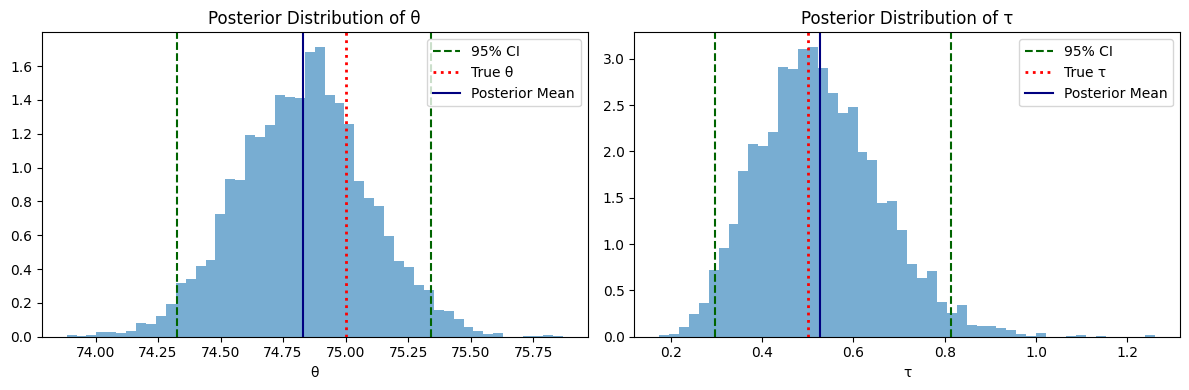

Metropolis-Within-Gibbs Bayesian Inference Results (n = 30):
True population mean (θ): 75.00
95% Credible Interval for θ: [74.33, 75.34]
Posterior mean for θ: 74.83

True population τ: 0.50
95% Credible Interval for τ: [0.30, 0.81]
Posterior mean for τ: 0.53


In [46]:
######## Well tuned proposal scaling parameters
# Hyperparameters for the prior on theta (now using a Cauchy prior)
theta0 = 80.0       # location parameter for the Cauchy prior on theta
# (For the Cauchy prior, we choose a scale parameter; here we use 10)
cauchy_scale = 10

# Allocate arrays to store samples
theta_chain = np.zeros((C, G))
tau_chain   = np.zeros((C, G))

# Initialize chains (starting values can be arbitrary)
theta_chain[:, 0] = 60.0
tau_chain[:, 0]   = 1.0

# ---------------------------
# Metropolis-within-Gibbs Sampler (Q2)
# ---------------------------
# Tuning parameters:
proposal_sd_theta = 0.50    # standard deviation for the symmetric random walk for theta
s_tau = 0.35                # tuning parameter for the dependent proposal for tau

# ---------------------------
# Define the joint (unnormalized) log density
# ---------------------------
def log_joint(theta, tau, x, theta0, cauchy_scale):
    """
    Unnormalized log joint density for (theta, tau) given data x.
    Likelihood:   ∏_{i=1}^n N(x_i; theta, variance=1/tau)
    Prior for theta: Cauchy(theta0, scale=cauchy_scale)
    Prior for tau: Gamma(shape=alpha/2, scale=2/lam)
    (Constants not depending on theta or tau are omitted.)
    """
    n = len(x)
    # Log-likelihood (using that sigma = 1/sqrt(tau))
    log_lik = 0.5 * n * np.log(tau) - 0.5 * tau * np.sum((x - theta)**2)

    # Prior for theta: use a Cauchy density (heavy–tailed)
    log_prior_theta = stats.cauchy.logpdf(theta, loc=theta0, scale=cauchy_scale)

    # Prior for tau: Gamma with shape=alpha/2 and scale=2/lam.
    log_prior_tau = stats.gamma.logpdf(tau, a=alpha/2, scale=2/lam)

    return log_lik + log_prior_theta + log_prior_tau

for c in range(C):
    for g in range(1, G):
        # Current state
        theta_current = theta_chain[c, g-1]
        tau_current   = tau_chain[c, g-1]

        # --- Update tau using a dependent (truncated normal) proposal ---
        # tau proposal is stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
        #         loc=tau_t_minus_1, scale=s)
        # We use: truncnorm(a=-tau_current/s_tau, b=inf, loc=tau_current, scale=s_tau)
        a_val = -tau_current / s_tau  # lower bound in standardized units
        tau_prop_dist = stats.truncnorm(a=a_val, b=np.inf, loc=tau_current, scale=s_tau)
        tau_tilde = tau_prop_dist.rvs()

        # Compute the forward proposal density: q(tau_tilde | tau_current)
        q_forward = tau_prop_dist.pdf(tau_tilde)
        # Compute the backward density: q(tau_current | tau_tilde)
        a_rev = -tau_tilde / s_tau
        q_backward = stats.truncnorm(a=a_rev, b=np.inf, loc=tau_tilde, scale=s_tau).pdf(tau_current)

        # Compute the log joint densities (theta remains fixed at theta_current)
        log_target_tilde = log_joint(theta_current, tau_tilde, x, theta0, cauchy_scale)
        log_target_current = log_joint(theta_current, tau_current, x, theta0, cauchy_scale)

        # Include the proposal correction
        log_q_ratio = np.log(q_backward) - np.log(q_forward)
        delta_tau = (log_target_tilde - log_target_current) + log_q_ratio

        # Use a safe evaluation so that if delta_tau > 0 we set alpha_tau = 1 without exponentiating
        if delta_tau > 0:
            alpha_tau = 1.0
        else:
            alpha_tau = np.exp(delta_tau)

        # Accept/reject step for tau
        if stats.uniform().rvs() < alpha_tau:
            tau_chain[c, g] = tau_tilde
        else:
            tau_chain[c, g] = tau_current

        # --- Update theta using a symmetric random-walk proposal ---
        theta_tilde = theta_current + stats.norm(scale=proposal_sd_theta).rvs()
        # Now tau remains fixed at the newly updated value
        log_target_tilde = log_joint(theta_tilde, tau_chain[c, g], x, theta0, cauchy_scale)
        log_target_current = log_joint(theta_current, tau_chain[c, g], x, theta0, cauchy_scale)
        delta_theta = log_target_tilde - log_target_current
        if delta_theta > 0:
            alpha_theta = 1.0
        else:
            alpha_theta = np.exp(delta_theta)

        if stats.uniform().rvs() < alpha_theta:
            theta_chain[c, g] = theta_tilde
        else:
            theta_chain[c, g] = theta_current

# ---------------------------
# Diagnostics for the Modified Sampler (Q2)
# ---------------------------
burn = 400
posterior_theta = theta_chain[0, burn:]
posterior_tau   = tau_chain[0, burn:]

fig, ax = plt.subplots(1, 4, figsize=(14,3))
ax[0].set_title(r"$\theta$ Burn-In")
ax[1].set_title(r"$\tau$ Burn-In")
ax[2].set_title(r"$\theta$ Stationary Samples")
ax[3].set_title(r"$\tau$ Stationary Samples")
demo = 1000
for c in range(C):
    ax[0].plot(theta_chain[c, :burn], label=r"$\theta$ chain " + str(c))
    ax[1].plot(tau_chain[c, :burn], label=r"$\tau$ chain " + str(c))
    ax[2].plot(np.arange(burn, demo), theta_chain[c, burn:demo], label=r"$\theta$ chain " + str(c))
    ax[3].plot(np.arange(burn, demo), tau_chain[c, burn:demo], label=r"$\tau$ chain " + str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

# Posterior summaries and plots:
theta_ci = np.quantile(posterior_theta, [0.025, 0.975])
tau_ci   = np.quantile(posterior_tau, [0.025, 0.975])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# Posterior of theta
ax[0].hist(posterior_theta, bins=50, density=True, alpha=0.6)
ax[0].axvline(theta_ci[0], color="darkgreen", linestyle="--", label="95% CI")
ax[0].axvline(theta_ci[1], color="darkgreen", linestyle="--")
ax[0].axvline(m_true, color="red", linestyle=":", linewidth=2, label="True θ")
ax[0].axvline(posterior_theta.mean(), color="navy", label="Posterior Mean")
ax[0].set_title("Posterior Distribution of θ")
ax[0].set_xlabel("θ")
ax[0].legend()

# Posterior of tau
ax[1].hist(posterior_tau, bins=50, density=True, alpha=0.6)
ax[1].axvline(tau_ci[0], color="darkgreen", linestyle="--", label="95% CI")
ax[1].axvline(tau_ci[1], color="darkgreen", linestyle="--")
ax[1].axvline(tau_true, color="red", linestyle=":", linewidth=2, label="True τ")
ax[1].axvline(posterior_tau.mean(), color="navy", label="Posterior Mean")
ax[1].set_title("Posterior Distribution of τ")
ax[1].set_xlabel("τ")
ax[1].legend()

plt.tight_layout()
plt.show()

print(f"Metropolis-Within-Gibbs Bayesian Inference Results (n = {n}):")
print("====================================")
print(f"True population mean (θ): {m_true:.2f}")
print(f"95% Credible Interval for θ: [{theta_ci[0]:.2f}, {theta_ci[1]:.2f}]")
print(f"Posterior mean for θ: {posterior_theta.mean():.2f}")
print()
print(f"True population τ: {tau_true:.2f}")
print(f"95% Credible Interval for τ: [{tau_ci[0]:.2f}, {tau_ci[1]:.2f}]")
print(f"Posterior mean for τ: {posterior_tau.mean():.2f}")

Comparing the two MWG runs in Q2, notice that the second set of histograms are smoother and the Markov chain traceplots show noticeably better mixing.

Comparing Q1 with Q2, it's hard to say that either of the well-tuned MWG runs provided decisively better Bayesian inference than the other. What I would have expected is that in Q1 the independent τ proposal and the conjugate (normal) prior for θ would have demonstrated better mixing in the traceplot and a tighter credible interval. In Q2, the dependent τ proposal and the non‐normal θ prior would have likely resulted in higher autocorrelation (i.e. poorer mixing).

**prompt:** *Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*

**Answer:**

We do not necessarily need to analytically determine the full conditional distributions when performing Gibbs sampling.

When the full conditionals can be derived in closed form (e.g. conjugate models), it is ideal to sample directly from these full conditional distributions because this typically yields the lowest autocorrelation and most efficient exploration of the posterior.

However, in many realistic models the full conditionals are not available in closed form and may be intractable. As shown above, we can use a Metropolis–Hastings (MH) step within a Gibbs sampler, which is called Metropolis-within-Gibbs (MWG). The key insight is that the MH acceptance ratio requires only the target density up to a normalizing constant; the parts that would have complicated normalization in the full conditional cancel out in the ratio.

Therefore, if you can evaluate the joint density, you can update that parameter using an MH step. This means you do not have to derive or sample from the exact full conditional distribution analytically. The main downside of MWG is that it may lead to slower mixing or higher autocorrelation compared to Gibbs sampling with known full conditionals. This is because the efficiency of MH updates depends on how well the proposal distribution approximates the target’s shape.


### Q3

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$

This **transition kernel** $K$ means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain.


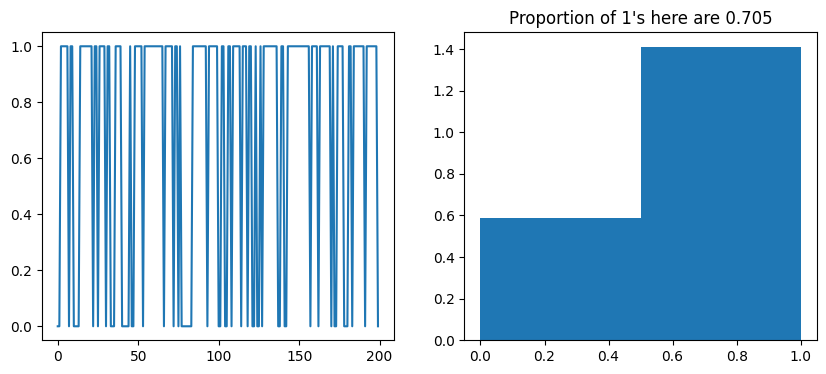

In [50]:
# Here's what it looks like if we flip coins
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]])
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])

fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

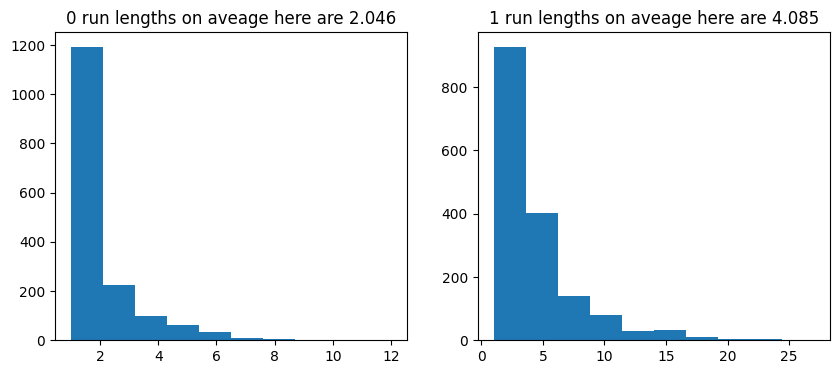

In [51]:
# Here's what it looks like if we flip coins
# with transition probabilties defind by K
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])

state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]
        run_length = 1

fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));


### Q3 Answer


Suppose we wish to target the distribution
$$
p(x^{(t)}) ={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}},
$$
and we use the proposal
$$
q(\tilde x^{(t)} | x^{(t-1)}) ={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}}.
$$

Since either $\tilde x^{(t)}$ = 0 or 1, what this formulation of the proposal $q$ means is that we propose $0$ or $1$ with equal probability. In essence, the probability of any state under $q$ given any previous state is always $1/2$.

Therefore, $q(x^{(t-1)}|\tilde x^{(t)}) = q(\tilde x^{(t)}|x^{(t-1)})$.

Because the proposal is symmetric (in fact independent of $x$), the MH acceptance probability for a proposal $\tilde x$ when the current state is $x$ is
$$
\alpha(x\to \tilde x) = \min\left\{1,\frac{p(\tilde x)}{p(x)}\right\}.
$$

So, the Metropolis-Hastings algorithm reduces to the Metropolis algorithm. Going through the cases:

1. If $x^{(t)} = 0$:  
   - Note that $p(0)=1/3$ and $p(1)=2/3$.  
   - If we propose $0$ with probability $1/2$:  
     $$\alpha(0 \to 0)=\min \left(1,\frac{1/3}{1/3}\right)=1.$$
     So we always accept; hence, $\Pr(0\to0)$ gets a contribution of $1/2 \cdot 1 = 1/2$.  
   - If we propose $1$ with probability $1/2$:  
     $$
     \alpha(0\to 1)=\min\left(1,\frac{2/3}{1/3}\right)=1.
     $$
     So we always accept the move. Thus, $\Pr(0\to1)=1/2$.  

2. If $x^{(t)} = 1$:
   - Note that $p(1)=2/3$ and $p(0)=1/3$.  
   - If we propose $1$ with probability $1/2$:  
     $$
     \alpha(1\to 1)=\min\left(1,\frac{2/3}{2/3}\right)=1,
     $$
     so we accept and remain in 1. This gives a contribution of $1/2$ to $\Pr(1\to1)$.  
   - If we propose $0$ with probability $1/2$:  
     $$
     \alpha(1\to 0)=\min\left(1,\frac{1/3}{2/3}\right)=\min(1,0.5)=0.5.
     $$
     Thus, with probability $1/2$ we accept the move to 0, and with probability $0.5$ we reject and remain in 1.  
    - The probability of moving from 1 to 0 is then $(1/2) \cdot (0.5)=0.25$, and the probability of remaining in 1 from proposing 0 is $(1/2) \cdot (0.5)=0.25$.  
   - Therefore, the total probability of remaining in state 1 when starting at 1 is $0.5 + 0.25 = 0.75$ and the probability of transitioning to 0 is $0.25$.

Thus, if we “organize” the transition probabilities with columns representing the current state, we have the kernel

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

Here is a simulation of this scenario which yields the kernel with the transition probabilities.

In [56]:
# Q3: Simulation of the two-state MH chain
p0_to_0 = 0
p0_to_1 = 0
p1_to_0 = 0
p1_to_1 = 0
starting_state_0 = 1
starting_state_1 = 0
T = 100000
s_t = np.zeros(T, dtype=int)  # state vector (0 or 1)

for t in range(1, T):
    # The proposal is independent: choose 0 or 1 with probability 0.5 each.
    proposal = 0 if stats.uniform().rvs() < 0.5 else 1
    current = s_t[t-1]
    if proposal == current:
        # If the proposed state is the same as current, accept automatically.
        s_t[t] = current
        if current == 0:
            p0_to_0 += 1
            starting_state_0 += 1
        else:
            p1_to_1 += 1
            starting_state_1 += 1
    else:
        # Compute acceptance probability.
        if current == 0:
            # p(0)=1/3, p(1)=2/3 so acceptance probability = 1 (since (2/3)/(1/3)=2 >1, min{1,2}=1)
            s_t[t] = proposal
            p0_to_1 += 1
            starting_state_1 += 1
        else:
            # current == 1: acceptance probability = min{1, (1/3)/(2/3)} = 0.5.
            if stats.uniform().rvs() < 0.5:
                s_t[t] = proposal
                p1_to_0 += 1
                starting_state_0 += 1
            else:
                s_t[t] = current
                p1_to_1 += 1
                starting_state_1 += 1

print(f"Acceptance probabilities after {T} runs:")
print(f"p(0→0) = {p0_to_0/starting_state_0:.3f}")
print(f"p(0→1) = {p0_to_1/starting_state_0:.3f}")
print(f"p(1→0) = {p1_to_0/starting_state_1:.3f}")
print(f"p(1→1) = {p1_to_1/starting_state_1:.3f}")


Acceptance probabilities after 100000 runs:
p(0→0) = 0.496
p(0→1) = 0.504
p(1→0) = 0.253
p(1→1) = 0.747
